# Network Operations Demo - Train, Test, and Deploy

This project demonstrates how to build an automated machine-learning (ML) pipeline for predicting network outages based on network-device telemetry. This notebook is the second part (out of 2) of the demo. This part demonstrates how to train, test and deploy a model and use offline and real-time data from the feature store.

**In this notebook:**
* **Create a Feature Vector that consists of data joined from the three feature sets you created**
* **Create an offline dataset from the feature vector to feed the ML training process**
* **Run automated ML Pipeline which train, test, and deploy the model**
* **Test the deployed real-time serving function**

When you finish this notebook, you should have a running network-device failure prediction system.

## Get and init the MLRun project

In [1]:
import os
import numpy as np
import mlrun
import mlrun.feature_store as fstore

# Create the project
project = mlrun.get_or_create_project('network-operations', "./", user_project=True)

> 2022-06-07 11:09:33,626 [info] loaded project network-operations from MLRun DB


## Create a new Feature Vector
The goal is to create a single dataset that contain datas from the static devices dataset, the device metrics, and the labels.
You'll define a **Feature Vector** and specify the desired features. When the vector is retrieved the feature store automatically and correctly joins the data from the different feature sets based on the entity (index) keys and the timestamp values.

To define and save the `device_features` feature vector

In [2]:
# Define the `device_features` Feature Vector
fv = fstore.FeatureVector('device_features',
                          features=['device_metrics.*', 'static.*'], 
                          label_feature='device_labels.is_error')

# Save the Feature Vector to MLRun's feature store DB
fv.save()

## Get an offline dataset for the feature vector
Once you have defined the feature vector and ingested some data, you can request the feature store to create an offline dataset, e.g. a snapshot of the data between the dates you want available to be loaded as parquet or csv files or as a pandas Dataframe.

you can later reference the created offline dataset via a special artifact url (`fv.url`).

**Make sure you run this AFTER the feature set data was ingested (using batch or real-time)**

In [3]:
# Request (get or create) the offline dataset from the feature store and save to a parquet target
dataset_ref = fstore.get_offline_features(fv, target=mlrun.datastore.targets.ParquetTarget())

# Get the generated offline dataset as a pandas DataFrame
dataset = dataset_ref.to_dataframe()
print("\nTraining set shape:", dataset.shape)
dataset.head()

> 2022-06-07 11:09:34,542 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/network-operations-yonatans/FeatureStore/device_features/parquet/vectors/device_features-latest.parquet', 'status': 'ready', 'updated': '2022-06-07T11:09:34.542575+00:00', 'size': 2269128}

Training set shape: (33600, 46)


,cpu_utilization_avg_1h,cpu_utilization_avg_6h,cpu_utilization_min_1h,cpu_utilization_min_6h,cpu_utilization_max_1h,cpu_utilization_max_6h,throughput_avg_1h,throughput_avg_6h,throughput_min_1h,throughput_min_6h,...,models_8,models_9,country_A,country_B,country_C,country_D,country_E,country_F,country_G,is_error
0,71.704891,71.704891,71.704891,71.704891,71.704891,71.704891,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,False
1,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,False
2,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,True
3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,True
4,67.613178,67.613178,67.613178,67.613178,67.613178,67.613178,225.246626,225.246626,225.246626,225.246626,...,0,0,0,0,0,1,0,0,0,False


In [4]:
# Verify that the dataset contains proper labels (must have both True & False values)
unique = dataset.is_error.unique()
assert len(unique) == 2, "dataset does not contain both label values. ingest a bigger dataset"

## Model training and deployment using the feature vector
Now that the dataset is ready for training, you need to define the model training, testing and deployment process.

Build an automated ML pipeline that uses pre-baked serverless training, testing and serving functions from [MLRun's functions marketplace](https://www.mlrun.org/marketplace/). The pipeline has three steps:
* Train a model using data from the feature vector you created and save it to the model registry
* Run model test/evaluation with a portion of the data
* Deploy a real-time serving function that uses the newly trained model, and enrich/impute the features with data from the real-time feature vector 

You can see the [**workflow code**](./src/workflow.py). You can run this workflow locally, in a CI/CD framework, or over Kubeflow. In practice you can create different workflows for development and production.

The workflow/pipeline can be executed using the MLRun SDK (`project.run()` method) or using CLI commands (`mlrun project`), and can run directly from the source repo (GIT). See details in MLRun [**Projects and Automation documentation**](https://docs.mlrun.org/en/latest/projects/overview.html).

When you run the workflow you can set arguments and destination for the different artifacts. The pipeline progress is shown in the notebook. Alternatively you can check the progress, logs, artifacts, etc. in the MLRun UI.

If you want to run the same using CLI, type:

```python
    mlrun project -n myproj -r ./src/workflow.py .
```

The [**workflow code**](./src/workflow.py) code uses the `get_offline_features` function from [MLRun's functions marketplace](https://www.mlrun.org/marketplace/).
This function allows to retrieve offline feature vector result or alternatevly create a feature vector for you and retrieve the results.
This demo already contains a feature vector instance as demonstrated above, so the example below matches this case. If you want the workflow to create a feature vector for you, use this template:

```python
model_name = "netops"

# run the workflow
run_id = project.run(
    workflow_path="./src/workflow.py",
    arguments={
        "vector_name": 'device_features', # feature vector name instead of uri.
        "features": ['device_metrics.*', 'static.*'], # features for the feature vector definition
        "label_column": 'device_labels.is_error',
        "model_name": model_name
    },
    watch=True)
```

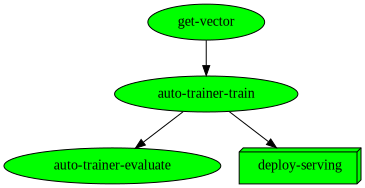

uid,start,state,name,parameters,results
...70efdd3c,Jun 07 11:10:18,completed,auto-trainer-evaluate,label_columns=device_labels.is_errormodel=store://artifacts/network-operations-yonatans/model:be311dc3-a9ed-4574-8899-fb039b337f71,evaluation_accuracy=0.8857142857142857evaluation_f1_score=0.09859154929577466evaluation_precision_score=0.23204419889502761evaluation_recall_score=0.06259314456035768
...474a269d,Jun 07 11:09:56,completed,auto-trainer-train,model_class=sklearn.ensemble.RandomForestClassifier,accuracy=0.8857142857142857f1_score=0.09859154929577466precision_score=0.23204419889502761recall_score=0.06259314456035768
...95b1ea5a,Jun 07 11:09:43,completed,get_vector,"feature_vector=store://feature-vectors/network-operations-yonatans/device_featuresfeatures=[]label_feature=device_labels.is_errorstart_time=now-7dend_time=nowentity_timestamp_column=timestamptarget={'name': 'parquet', 'kind': 'parquet'}update_stats=True",feature_vector=store://feature-vectors/network-operations-yonatans/device_features


In [5]:
model_name = "netops"

# run the workflow
run_id = project.run(
    workflow_path="./src/workflow.py",
    arguments={
        "vector_name": fv.uri,
        "label_column": 'device_labels.is_error',
        "model_name": model_name
    },
    watch=True)

## Test the Live Model Endpoint
To test the live model endpoint, first grab a list of IDs from the static feature set it produced. Then use these IDs and send them through a loop to the live endpoint.

### Grab IDs from the static devices table

In [6]:
# Load the static feature set
fset = fstore.get_feature_set('static')

# Get a dataframe from the feature set
devices = fset.to_dataframe().reset_index()['device'].values
print('Devices sample:', devices[:4])

Devices sample: ['0131829476827' '6909970884180' '2796684608801' '7170281666639']


### Send a sample ID to the model endpoint

In [7]:
serving_fn = project.get_function('serving')
serving_fn.invoke(path=f'/v2/models/{model_name}/infer', body={'inputs': [[devices[0]]]})

> 2022-06-07 11:11:27,242 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-network-operations-yonatans-serving.default-tenant.svc.cluster.local:8080/v2/models/netops/infer'}


{'id': 'c0ccffb7-96b2-4e8c-84bb-a7d7d280203e',
 'model_name': 'netops',
 'outputs': [False]}

### Continously send IDs to the model 

In [8]:
import random
import time

MSGS_TO_SEND = 5
IDS_PER_MSG = 2
TIMEOUT_BETWEEN_SENDS = 10
for i in range(MSGS_TO_SEND):
    ids_for_prediction = [[random.choice(devices)] for i in range(IDS_PER_MSG)]
    resp = serving_fn.invoke(path=f'/v2/models/{model_name}/infer', body={'inputs': ids_for_prediction})
    print('Sent:', ids_for_prediction)
    print('Response:', resp)
    print('Predictions:', list(zip(ids_for_prediction, resp['outputs'])))
    time.sleep(TIMEOUT_BETWEEN_SENDS)

> 2022-06-07 11:11:27,329 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-network-operations-yonatans-serving.default-tenant.svc.cluster.local:8080/v2/models/netops/infer'}
Sent: [['1876820575247'], ['7759302294685']]
Response: {'id': '5ff4e8e4-30a2-46e2-9cbb-a7cade0dd9eb', 'model_name': 'netops', 'outputs': [False, False]}
Predictions: [(['1876820575247'], False), (['7759302294685'], False)]
> 2022-06-07 11:11:37,399 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-network-operations-yonatans-serving.default-tenant.svc.cluster.local:8080/v2/models/netops/infer'}
Sent: [['4841678372420'], ['2697569332249']]
Response: {'id': 'b216a592-a6e2-4aab-8fdb-02cdcc2fb895', 'model_name': 'netops', 'outputs': [False, False]}
Predictions: [(['4841678372420'], False), (['2697569332249'], False)]
> 2022-06-07 11:11:47,481 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-network-operations-yonatans-serving.default-tenant.svc.cluster.local:8080/